<a href="https://colab.research.google.com/github/Lukec-lehighu/CSE337-Labs/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


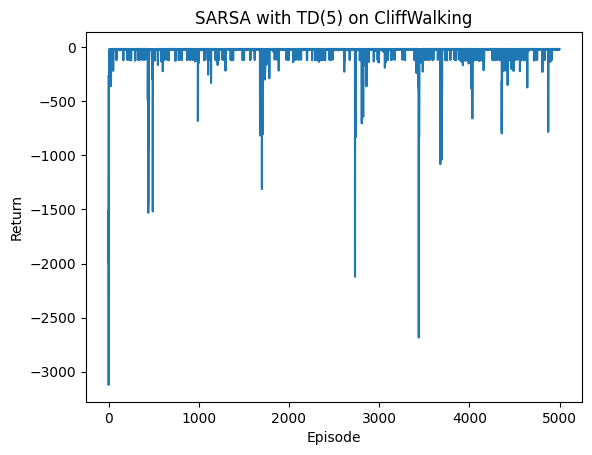

6

In [1]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.1         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 5000

SAMPLE_EFF_THRESH = -30

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

def nSarsa():
  global Q

  # Track returns
  episode_returns = []

  sample_efficiency = -1

  for ep in range(n_episodes):
      state, _ = env.reset()
      action = epsilon_greedy(state)

      # Buffers to store the trajectory
      states = deque()
      actions = deque()
      rewards = deque()

      T = float("inf")
      t = 0
      G = 0
      done = False

      while True:
          if t < T:
              # Take real step in the environment
              next_state, reward, terminated, truncated, _ = env.step(action)
              done = terminated or truncated

              states.append(state)
              actions.append(action)
              rewards.append(reward)

              if done:
                  T = t + 1
              else:
                  next_action = epsilon_greedy(next_state)
                  state = next_state
                  action = next_action

          # Time index for state/action to update
          tau = t - (n_step + 1)
          if tau >= 0:
              G = 0.0
              # accumulate discounted rewards
              for i in range(tau+1, min(tau + n_step, T)):
                  G += (gamma ** (i - tau - 1)) * rewards[i]
              if tau + n_step < T:
                  s_tau_n = states[tau + n_step]
                  a_tau_n = actions[tau + n_step]
                  G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

              # TODO: Update Q[states[tau], actions[tau]] toward G
              Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

          if tau == T - 1:
              break

          t += 1

      episode_returns.append(sum(rewards))
      if episode_returns[-1] >= SAMPLE_EFF_THRESH and sample_efficiency < 0:
        sample_efficiency = ep


  # Plot learning curve
  plt.plot(episode_returns)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title("SARSA with TD(5) on CliffWalking")
  plt.show()
  return sample_efficiency

nSarsa()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_policy(Q, title="SARSA", frozen_lake=False):
  # Reshape Q table to a 4x12 grid
  dims = (4,12)
  if frozen_lake:
    dims = (4,4)

  Q_grid = Q.reshape((dims[0], dims[1], n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(dims[0], dims[1]))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title(f"Optimal Policy ({title})")
  plt.show()


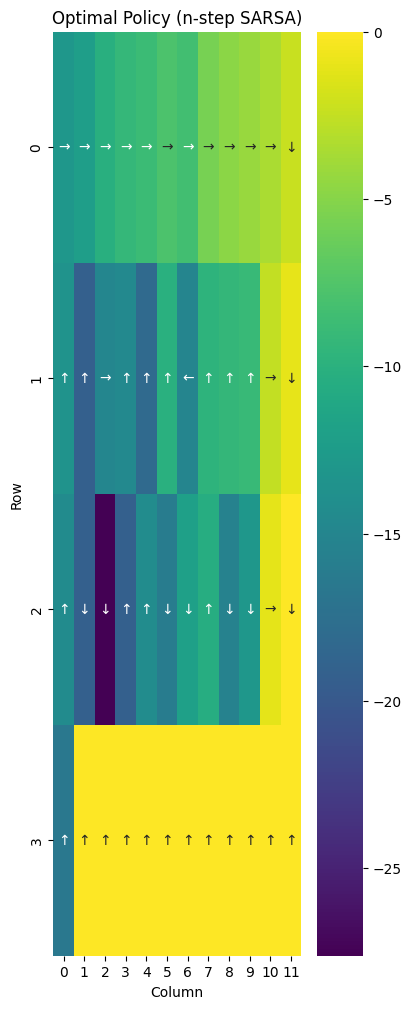

In [5]:
plot_policy(Q, title='n-step SARSA')

# Analysis

N-Step SARSA converged much faster than regular SARSA. It took less steps to reach a policy that would return a consistently high return value. N-Step SARSA produced similar behavior to regular SARSA near the cliff. Both methods produced a path that takes the furthest route possible from the cliff. The main difference between the two policies when it comes to route selection would be that N-Step SARSA's policy is braver and sometimes moves towards the cliff while regular SARSA does not.



## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




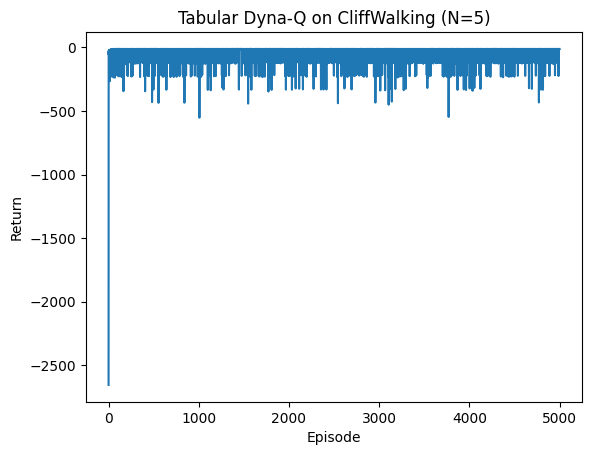

Sample Efficiency: 1


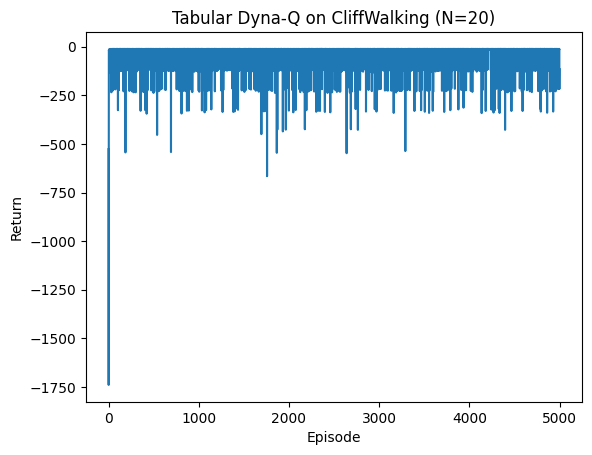

Sample Efficiency: 2


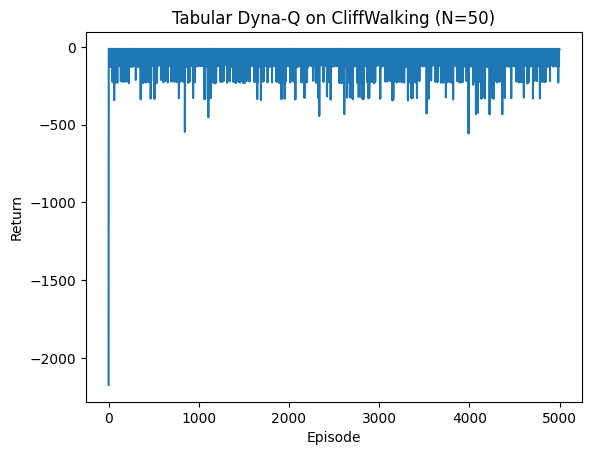

Sample Efficiency: 1


In [6]:
import random

# Environment
env = gym.make("CliffWalking-v1")

def DynaQ(n_simulated):
  global Q

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  #model
  model = {}

  # Track returns
  episode_returns = []

  sample_efficiency = -1

  for ep in range(n_episodes):
      state, _ = env.reset()
      rewards = []

      while True:
        action = epsilon_greedy(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
          break

        Q[state, action] = Q[state, action] + alpha*(reward + gamma*max(Q[next_state]) - Q[state, action])

        model[state] = model.get(state, {})
        model[state][action] = (reward, next_state)
        rewards.append(reward)
        state = next_state #update state

        for i in range(n_simulated):
          sim_state = random.choice(list(model.keys()))
          action = random.choice(list(model[sim_state].keys()))
          reward, next_state = model[sim_state][action]

          Q[sim_state, action] = Q[sim_state, action] + alpha*(reward + gamma*max(Q[next_state]) - Q[sim_state, action])

      episode_returns.append(sum(rewards))
      if episode_returns[-1] >= SAMPLE_EFF_THRESH and sample_efficiency < 0:
        sample_efficiency = ep

  # Plot learning curve
  plt.plot(episode_returns)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"Tabular Dyna-Q on CliffWalking (N={n_simulated})")
  plt.show()

  return sample_efficiency, episode_returns

print(f"Sample Efficiency: {DynaQ(5)[0]}")
print(f"Sample Efficiency: {DynaQ(20)[0]}")
print(f"Sample Efficiency: {DynaQ(50)[0]}")

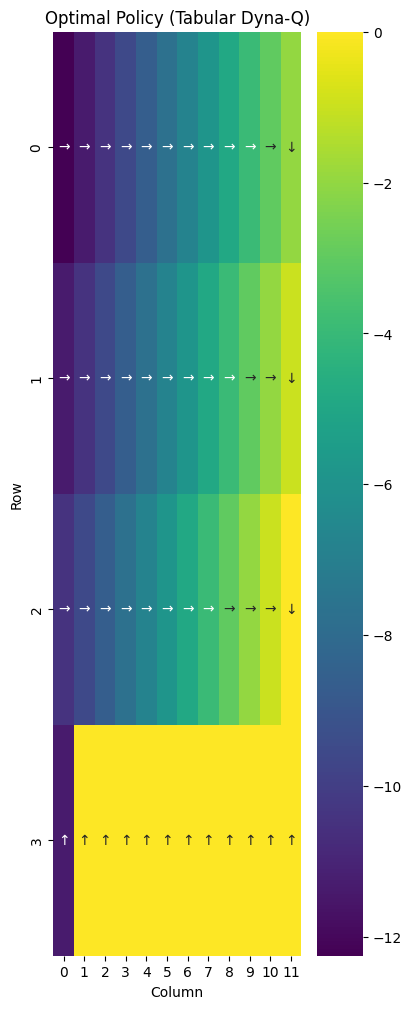

In [7]:
plot_policy(Q, "Tabular Dyna-Q")

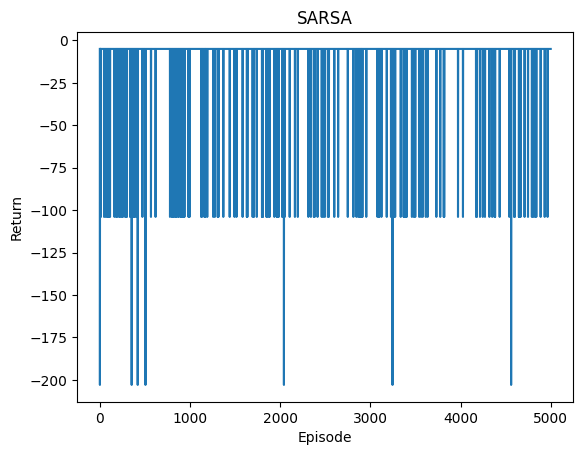

Sample efficiency: 0


In [8]:
#sarsa code for comparison
def sarsa(slippery=False):
  global Q
  # Q-learning parameters
  Q = np.zeros((n_states, n_actions))

  # Create the environment
  env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=slippery)

  sample_efficiency = -1

  rewards=[] #keep track of the sum of rewards
  for episode in range(n_episodes):
      state, info = env.reset()
      done = False
      total_reward = 0

      action = epsilon_greedy(state)
      for step in range(n_step):
          next_state, reward, terminated, truncated, info = env.step(action)
          total_reward += reward

          next_action = epsilon_greedy(next_state)

          #calculate Q values
          Q[state, action] = Q[state, action] + alpha*(reward + gamma*Q[next_state, next_action] - Q[state, action])

          state = next_state
          action = next_action

          if terminated or truncated:
              break
      rewards.append(total_reward)
      if rewards[-1] >= SAMPLE_EFF_THRESH and sample_efficiency < 0:
        sample_efficiency = episode

  plt.plot(rewards)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"SARSA")
  plt.show()

  env.close()
  return sample_efficiency

print(f"Sample efficiency: {sarsa()}")

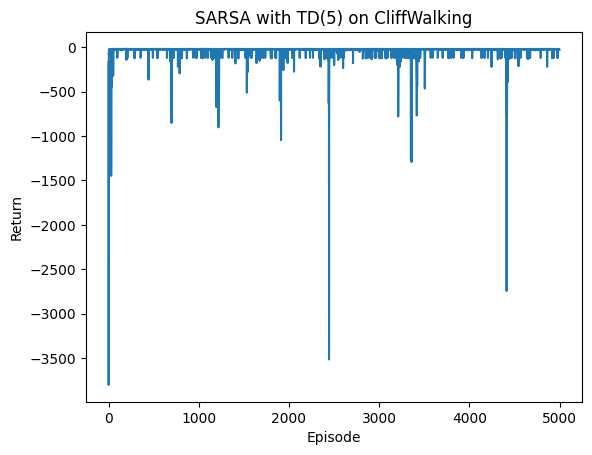

Sample efficiency: 5


In [9]:
print(f"Sample efficiency: {nSarsa()}") # for comparison

# Analysis:

**Sample efficiency** (Threshold = -30):
  - DynaQ (N=5): 3
  - DynaQ (N=20): 2
  - DynaQ (N=50): 2
  - Sarsa TD: 0
  - Sarsa: 0

**Stability near the cliff**:
  - DynaQ: walks much closer to cliff but finds most efficient policy
  - Sarsa TD and Sarsa: Take steps further from cliff. Less efficient policy but much more stable.

**Sensitivity to planning steps**:
  - Higher Ns result in a much more computational power required per episode. As N increases, the sample efficiency improves but by less and less each increase (diminishing returns). The ideal N would be low enough to not require too much computational power but still result in a good sample efficiency.

**Statistical robustness**:
 - *See cell below*

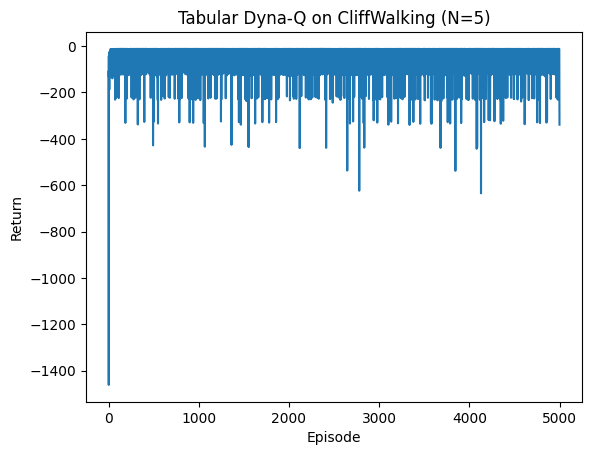

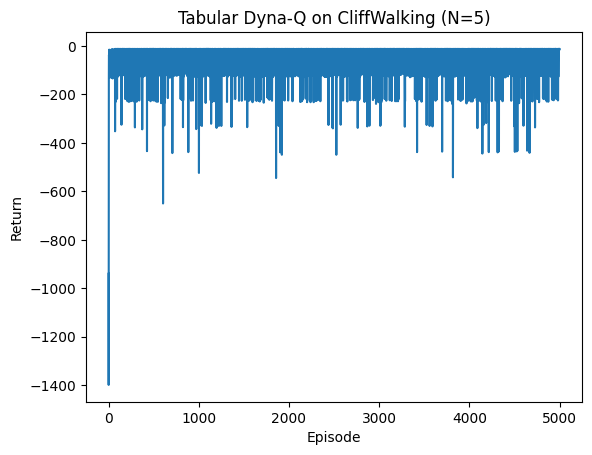

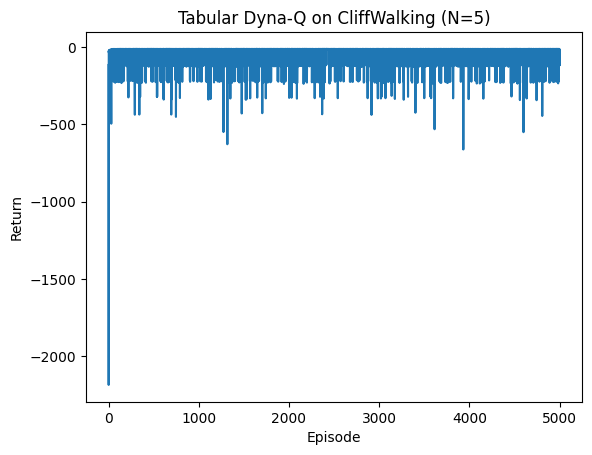

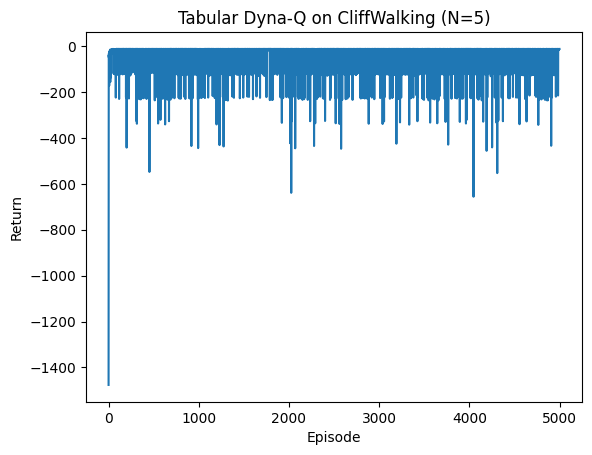

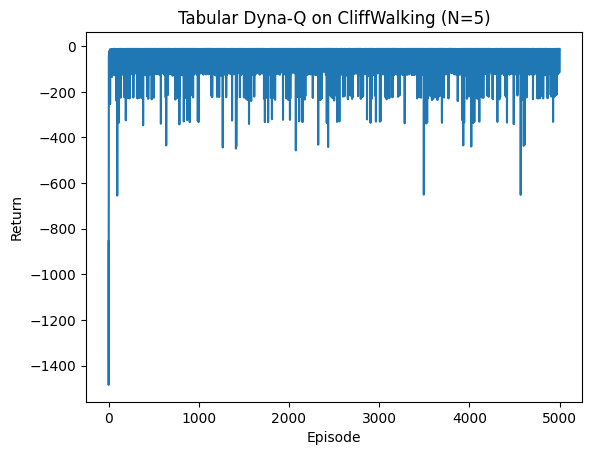

Mean: -45.04492 +- 70.38370334687905


In [10]:
from statistics import stdev, mean

final_returns = []
for i in range(5):
  final_returns.extend(DynaQ(5)[1])
print(f"Mean: {mean(final_returns)} +- {stdev(final_returns)}")

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).


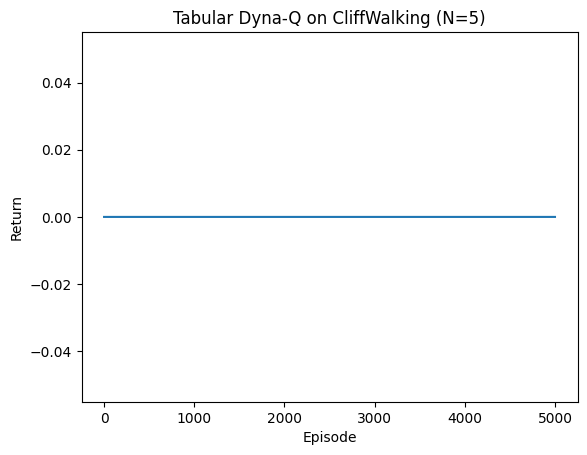

Sample efficiency: 0


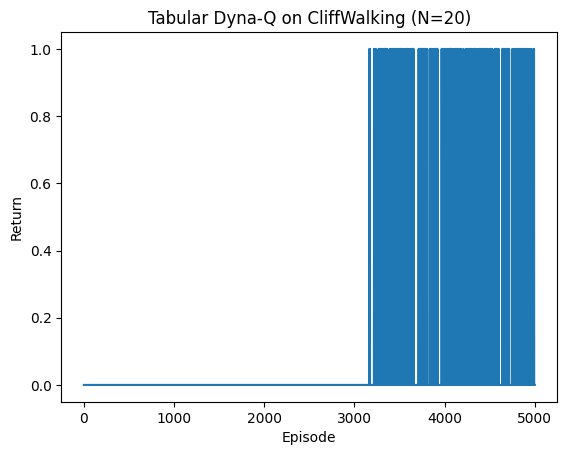

Sample efficiency: 0


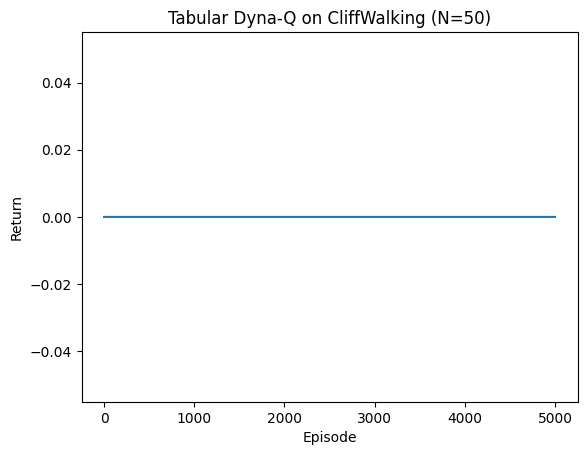

Sample efficiency: 0


In [16]:
env = gym.make("FrozenLake-v1")
def DynaQ_Stochastic(n_simulated):
  global Q

  n_states = env.observation_space.n
  n_actions = env.action_space.n

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  #model
  model = {}

  # Track returns
  episode_returns = []

  sample_efficiency = -1

  for ep in range(n_episodes):
      state, _ = env.reset()
      rewards = []

      while True:
        action = epsilon_greedy(state)

        next_state, reward, terminated, truncated, _ = env.step(action)

        target = reward + gamma*max(Q[next_state])
        if terminated or truncated:
          target = reward
        Q[state, action] = Q[state, action] + alpha*(target - Q[state, action])

        model[state] = model.get(state, {})
        model[state][action] = model.get((state, action), []) + [(reward, next_state),]
        rewards.append(reward)
        state = next_state #update state

        if terminated or truncated:
          break

        for i in range(n_simulated):
          sim_state = random.choice(list(model.keys()))
          action = random.choice(list(model[sim_state].keys()))

          reward, next_state = random.choice(model[sim_state][action])

          target = reward + gamma*max(Q[next_state])
          if terminated or truncated:
            target = reward
          Q[sim_state, action] = Q[sim_state, action] + alpha*(target - Q[sim_state, action])

      episode_returns.append(sum(rewards))
      if episode_returns[-1] >= SAMPLE_EFF_THRESH and sample_efficiency < 0:
        sample_efficiency = ep

  # Plot learning curve
  plt.plot(episode_returns)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"Tabular Dyna-Q on CliffWalking (N={n_simulated})")
  plt.show()
  env.close()
  return sample_efficiency, episode_returns

print(f"Sample efficiency: {DynaQ_Stochastic(5)[0]}")
print(f"Sample efficiency: {DynaQ_Stochastic(20)[0]}")
print(f"Sample efficiency: {DynaQ_Stochastic(50)[0]}")

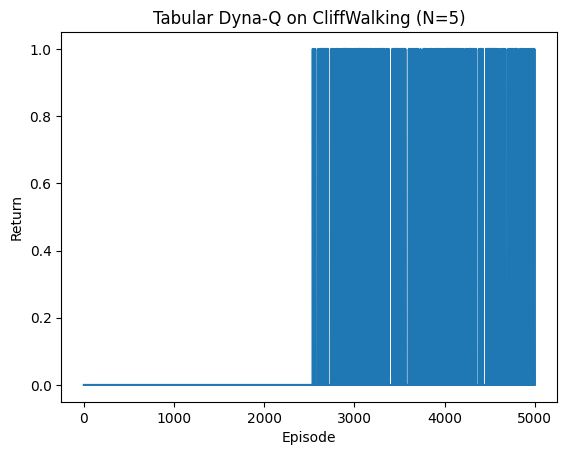

Sample efficiency: 0


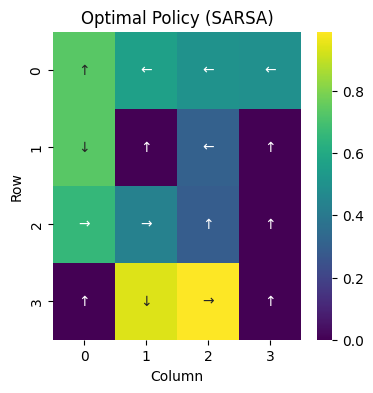

In [23]:
env = gym.make("FrozenLake-v1")
print(f"Sample efficiency: {DynaQ_Stochastic(5)[0]}")
plot_policy(Q, frozen_lake=True)

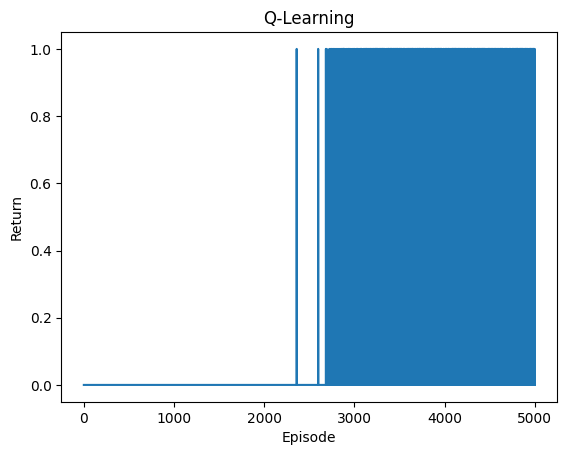

In [25]:
def q_learning(slippery=False):
  global Q
  # Create the environment
  env = gym.make("FrozenLake-v1")

  n_states = env.observation_space.n
  n_actions = env.action_space.n

  #reset Q values
  Q = np.zeros((n_states, n_actions))

  rewards=[]
  for episode in range(n_episodes):
      state, info = env.reset()
      done = False
      total_reward = 0

      for step in range(n_episodes):
        action = epsilon_greedy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        #calculate Q values
        target = reward + gamma*max(Q[next_state])
        if terminated or truncated:
          target = reward
        Q[state, action] = Q[state, action] + alpha*(target - Q[state, action])

        state = next_state

        if terminated or truncated:
            break
      rewards.append(total_reward)
      #print(f"Q-Learning Episode {episode+1}: total reward = {total_reward}")

  plt.plot(rewards)
  plt.xlabel("Episode")
  plt.ylabel("Return")
  plt.title(f"Q-Learning")
  plt.show()
  env.close()
  return rewards

_=q_learning()

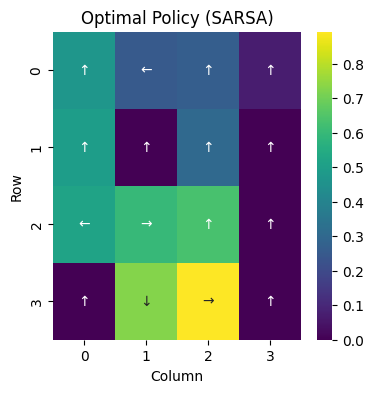

In [26]:
plot_policy(Q, frozen_lake=True)

**Effect of stochastic modeling**:
 - Storing a distribution over (s', r) allows for the model to learn of more possible routes which comes in handy with the slippery environment. Since the model has a high chance of slipping, it will spend more time trying to find an optimal policy. By storing many past states and rewards, the algorithm can build a better model of the environment with more information. Storing the most recent outcome will limit the model's information and risks the algorithm spending more time finding an optimal policy or not finding one at all.

# Robustness:

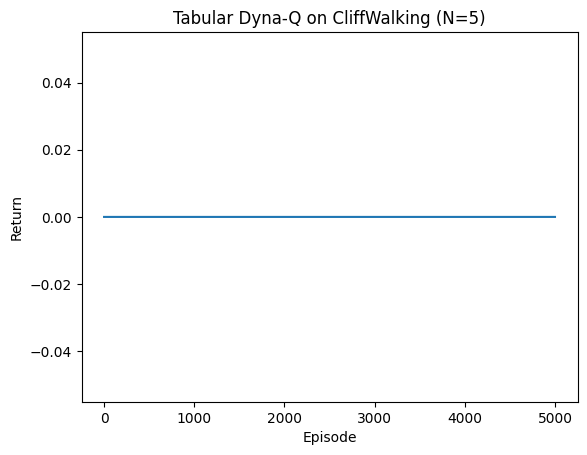

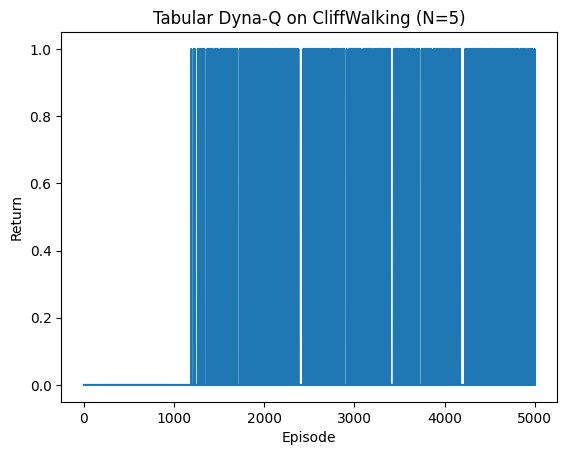

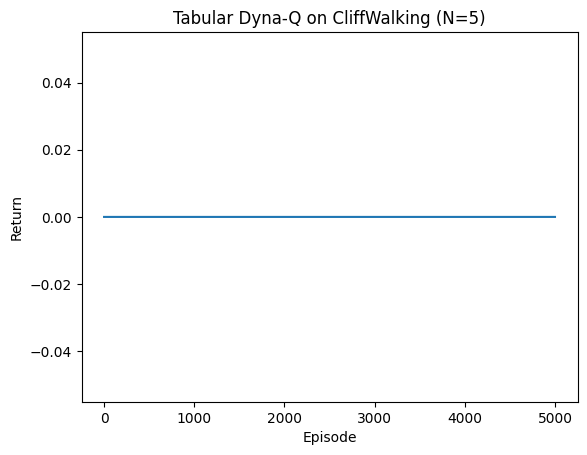

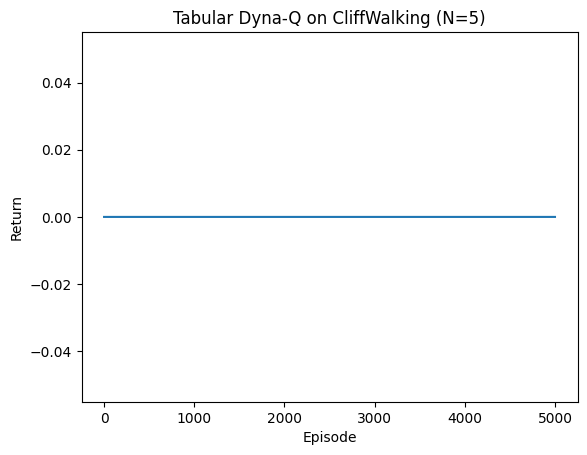

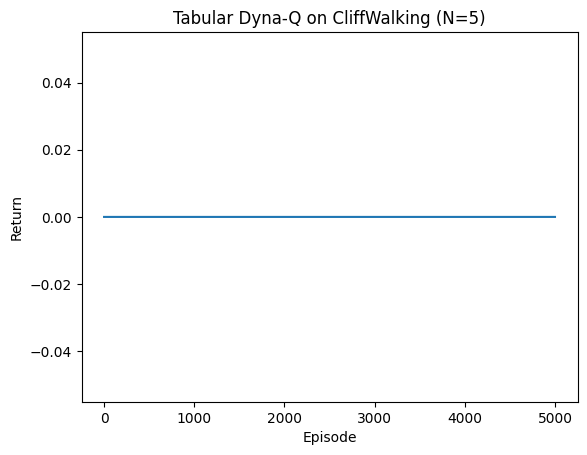

Mean: 0.02824 +- 0.16566110027404068


In [27]:
final_returns = []
for i in range(5):
  final_returns.extend(DynaQ_Stochastic(5)[1])
print(f"Mean: {mean(final_returns)} +- {stdev(final_returns)}")

# Discussion:

Dyna-Q helps here because it allows for the model to repeatedly try past steps that might have resulted in a slip in the past. This allows for a policy to be reached more quickly than regular Q learning, which isn't able to try as many different paths without slipping and updating the policy to avoid that state.